<a href="https://colab.research.google.com/github/ritusingh-29/Hybrid-Legal-Document-Summarization/blob/main/baseline_tuning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install transformers datasets pandas matplotlib seaborn rouge-score sacrebleu bert-score sentencepiece torch tqdm evaluate --quiet

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BartTokenizer, BartForConditionalGeneration,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from datasets import load_dataset
import evaluate
from tqdm.notebook import tqdm

print("--- All libraries installed and imported successfully! ---")

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.1 MB/s eta 0:00:00
--- All libraries installed and imported successfully! ---


--- Starting Data Lead's Analysis Workflow ---

[STEP 1] Loading the BillSum dataset from Hugging Face...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/91.8M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/15.8M [00:00<?, ?B/s]

data/ca_test-00000-of-00001.parquet:   0%|          | 0.00/6.12M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18949 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3269 [00:00<?, ? examples/s]

Generating ca_test split:   0%|          | 0/1237 [00:00<?, ? examples/s]


Dataset loaded successfully. Verifying the train/test splits...
DatasetDict({
    train: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 18949
    })
    test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 3269
    })
    ca_test: Dataset({
        features: ['text', 'summary', 'title'],
        num_rows: 1237
    })
})

Analysis: The dataset is pre-split.
--> We will use the 18949 examples in 'train' for fine-tuning our model.
--> We will use the 3269 examples in 'test' for the final evaluation.

[STEP 2] Creating visualizations to understand the data...


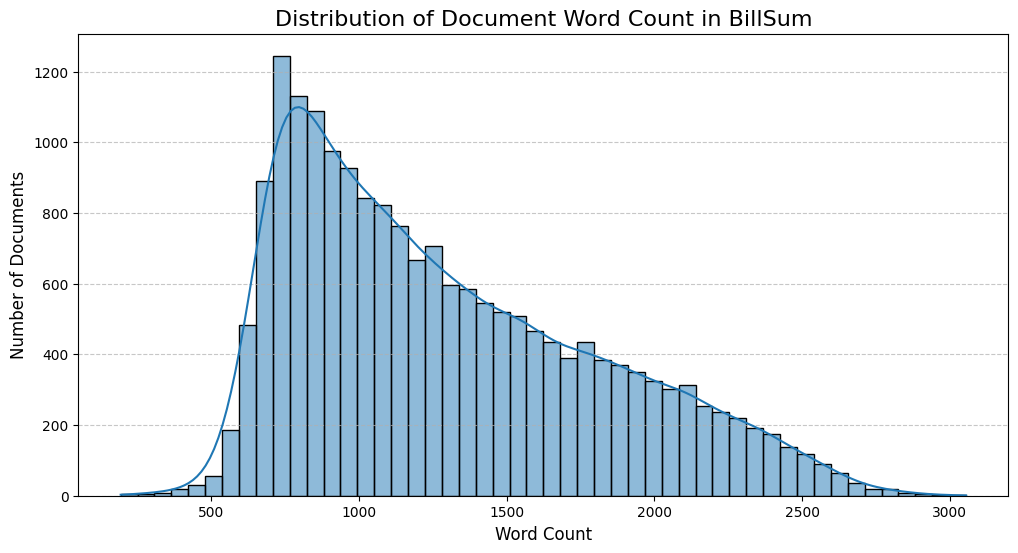


Analysis: This chart shows that most documents are under 5,000 words, but a significant number are much longer. This confirms that a strategy to handle long documents is necessary.


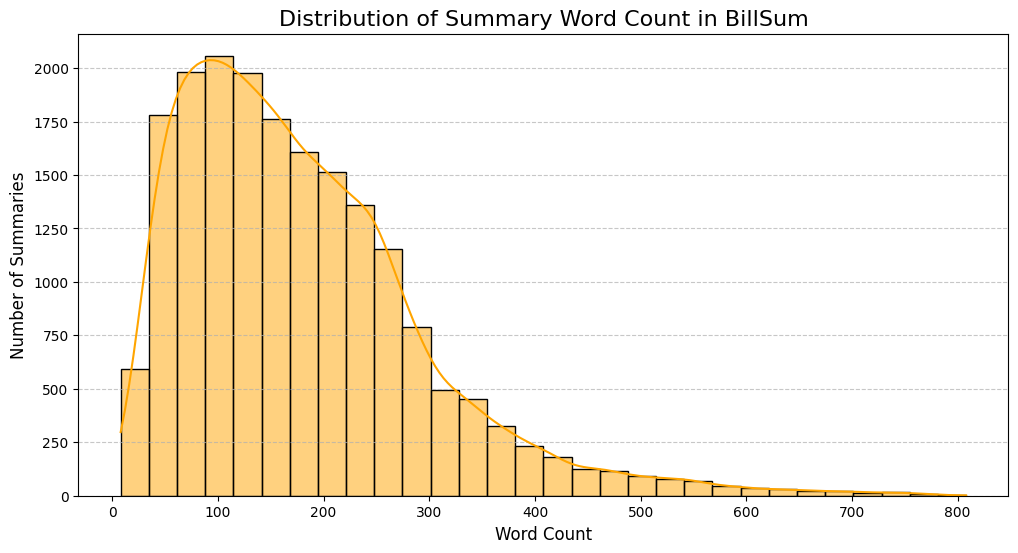


Analysis: This chart shows that most human-written summaries are between 100 and 300 words long. This helps us set a reasonable 'max_output_len' for our model's generated summaries.

[STEP 3] Analyzing the tokenization process...


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

A sample document with 650 words was converted into 1788 tokens.
This is important because our model has a maximum token limit.

[STEP 4] Defining the strategy for handling long documents...

Analysis: Our data analysis shows that many documents will be longer than the model's input limit (512 tokens for BART). We have two main strategies:

1.  TRUNCATION (The Baseline Method): This involves simply cutting off the text at the 512-token limit. It's fast but loses information. We will use this method for our baseline experiment to match the Gurrapu et al. paper. The code for this is in the main training script's 'BillSumDataset' class.

2.  CHUNKING (An Advanced Method): This involves breaking a long document into smaller, overlapping chunks. While this is a valid strategy, our project will use an even smarter approach for our improved model: a HYBRID PIPELINE. Our extractive filter will act as an intelligent 'chunker' by selecting only the most important sentences.

Decision: The Data L

In [ ]:

!pip install transformers datasets pandas matplotlib seaborn --quiet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import BartTokenizer

print("--- Starting Data Lead's Analysis Workflow ---")

print("\n[STEP 1] Loading the BillSum dataset from Hugging Face...")

ds = load_dataset("FiscalNote/billsum")

print("\nDataset loaded successfully. Verifying the train/test splits...")
print(ds)

# The dataset is already split into 'train', 'test', and 'ca_test'.
train_ds_size = len(ds['train'])
test_ds_size = len(ds['test'])

print(f"\nAnalysis: The dataset is pre-split.")
print(f"--> We will use the {train_ds_size} examples in 'train' for fine-tuning our model.")
print(f"--> We will use the {test_ds_size} examples in 'test' for the final evaluation.")

print("\n[STEP 2] Creating visualizations to understand the data...")

df = ds['train'].to_pandas()

df['text_word_count'] = df['text'].str.split().str.len()
df['summary_word_count'] = df['summary'].str.split().str.len()

# --- Visualization 1: Distribution of Document Lengths ---
plt.figure(figsize=(12, 6))
sns.histplot(df['text_word_count'], bins=50, kde=True)
plt.title('Distribution of Document Word Count in BillSum', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Number of Documents', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nAnalysis: This chart shows that most documents are under 5,000 words, but a significant number are much longer. This confirms that a strategy to handle long documents is necessary.")

# --- Visualization 2: Distribution of Summary Lengths ---
plt.figure(figsize=(12, 6))
sns.histplot(df['summary_word_count'], bins=30, kde=True, color='orange')
plt.title('Distribution of Summary Word Count in BillSum', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Number of Summaries', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\nAnalysis: This chart shows that most human-written summaries are between 100 and 300 words long. This helps us set a reasonable 'max_output_len' for our model's generated summaries.")

print("\n[STEP 3] Analyzing the tokenization process...")

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

sample_text = df.iloc[0]['text']
sample_summary = df.iloc[0]['summary']

tokenized_output = tokenizer(sample_text)
num_tokens = len(tokenized_output['input_ids'])

print(f"A sample document with {len(sample_text.split())} words was converted into {num_tokens} tokens.")
print("This is important because our model has a maximum token limit.")

print("\n[STEP 4] Defining the strategy for handling long documents...")

print("""
Analysis: Our data analysis shows that many documents will be longer than the model's input limit (512 tokens for BART). We have two main strategies:

1.  TRUNCATION (The Baseline Method): This involves simply cutting off the text at the 512-token limit. It's fast but loses information. We will use this method for our baseline experiment to match the Gurrapu et al. paper. The code for this is in the main training script's 'BillSumDataset' class.

2.  CHUNKING (An Advanced Method): This involves breaking a long document into smaller, overlapping chunks. While this is a valid strategy, our project will use an even smarter approach for our improved model: a HYBRID PIPELINE. Our extractive filter will act as an intelligent 'chunker' by selecting only the most important sentences.

Decision: The Data Lead's responsibility is to confirm that TRUNCATION will be used for the baseline. The main training code already handles this.
""")

print("The dataset has been analyzed, visualized, and the processing strategy is confirmed.")

In [ ]:

# ==============================================================================
# 3. MODELING LEAD'S WORK: Data Preparation and Model Setup
# ==============================================================================
print("\n--- [Modeling Lead Task] Preparing Data and Model ---")

# --- Step 3.1: Data Preparation Class ---
# This class prepares the data according to the paper's "truncation" method.
class BillSumDataset(Dataset):
    def __init__(self, docs, summaries, tokenizer,
                 max_input_len=512,  # Set to 512 to match the Gurrapu et al. paper's truncation for BART
                 max_output_len=128): # Based on the data lead's analysis of summary lengths
        self.docs = docs
        self.summaries = summaries
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

    def __len__(self):
        return len(self.docs)

    def __getitem__(self, idx):
        doc = str(self.docs[idx])
        summary = str(self.summaries[idx])

        inputs = self.tokenizer(
            doc,
            max_length=self.max_input_len,
            truncation=True, # This is the key step for our baseline
            padding="max_length",
            return_tensors="pt"
        )
        targets = self.tokenizer(
            summary,
            max_length=self.max_output_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        labels = targets["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels
        }

# --- Step 3.2: Model Loading ---
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)
print(f"\nLoaded model and tokenizer for: {model_name}")

# Create the final datasets for training and testing
train_dataset = BillSumDataset(ds['train']['text'], ds['train']['summary'], tokenizer)
test_dataset = BillSumDataset(ds['test']['text'], ds['test']['summary'], tokenizer)


print("\n--- [Training/Evaluation Lead Task] Setting up Training ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- Hyperparameters from the Gurrapu et al. (2025) paper ---
batch_size = 16
epochs = 4
lr = 3e-5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = AdamW(model.parameters(), lr=lr)

total_steps = epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps
)

# --- Step 4.1: The Training Loop (Fine-Tuning) ---
print(f"\nStarting training for {epochs} epochs on {device}...")
model.train()
for epoch in range(epochs):
    print(f"--- Epoch {epoch+1}/{epochs} ---")
    epoch_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            return_dict=True
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Average training loss for epoch {epoch+1}: {avg_loss:.4f}")

# --- Step 4.2: The Evaluation Loop ---
print("\n--- Starting Final Evaluation on the Test Set ---")
rouge = evaluate.load("rouge")
bleu = evaluate.load("sacrebleu")
bertscore = evaluate.load("bertscore")

model.eval()
preds, refs = [], []
test_loader = DataLoader(test_dataset, batch_size=8) # Using a slightly larger batch size for faster evaluation

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"]

        gen_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=128,
            num_beams=4,
            early_stopping=True
        )

        batch_preds = tokenizer.batch_decode(gen_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        labels[labels == -100] = tokenizer.pad_token_id
        batch_refs = tokenizer.batch_decode(labels, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        preds.extend(batch_preds)
        refs.extend(batch_refs)

# --- Step 4.3: Calculate and Print Final Scores ---
rouge_scores = rouge.compute(predictions=preds, references=refs)
bleu_score = bleu.compute(predictions=preds, references=[[r] for r in refs])
bert_scores = bertscore.compute(predictions=preds, references=refs, lang="en")

print("\n\n=== FINAL EVALUATION RESULTS (BASELINE MODEL) ===")
print("ROUGE:", rouge_scores)
print("BLEU:", bleu_score)
print("BERTScore F1 mean:", sum(bert_scores['f1']) / len(bert_scores['f1']))



--- [Modeling Lead Task] Preparing Data and Model ---


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]


Loaded model and tokenizer for: facebook/bart-base

--- [Training/Evaluation Lead Task] Setting up Training ---

Starting training for 4 epochs on cuda...
--- Epoch 1/4 ---


Training Epoch 1:   0%|          | 0/1185 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# ==============================================================================
# 5. SAVE THE MODEL: Save your fine-tuned model for later
# ==============================================================================
# ==============================================================================
# PRO TIP: Mount your Google Drive to save the model permanently
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Now, set the output directory to a folder in YOUR Google Drive
output_dir = "/content/drive/MyDrive/My_ML_Project/baseline_tuning2" #<-- This is permanent!
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"\nModel and tokenizer permanently saved at {output_dir}")